#  目的
yに正規分布を用いる(σ0.5)

In [1]:
# path setting
EXP_NAME = "e020-sigma-05"
MODEL_NAME = "microsoft/deberta-v3-base"
COMPETITION_NAME = "automated_essay_scoring"

DATA_PATH = "data"
DATASET_NAME = f"{EXP_NAME}-{MODEL_NAME.split('/')[-1]}"
MODEL_OUTPUT_PATH = f"trained_models/{EXP_NAME}"

# experiment parameter
DEBUG = False
TRAINING = True
UPLOAD_DATA_TO_S3 = True
UPLOAD_DATA_TO_KAGGLE = True
WANDB = True

# model parameter
TRAINING_MAX_LENGTH = 512
# TRAINING_MAX_LENGTH = 1024
# TRAINING_MAX_LENGTH= 2048
SEED = 42
EPOCH = 3
LR = 2e-05
TRAIN_BS = 2  # 8
GRAD_ACC_NUM = 4  # 16
EVAL_BS = 2  # 8
SAVE_STEP = 0.1
EVAL_STEP = 0.1
NUM_LABELS = 6

SIGMA = 0.5

# TRAINED_MODEL_PATH = "/notebooks/automated_essay_scoring/trained_models/e012-cls-with-qwkloss"

In [2]:
!nvidia-smi

Sun May 19 06:21:43 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.04   Driver Version: 525.116.04   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro P5000        Off  | 00000000:00:05.0 Off |                  N/A |
| 26%   37C    P8     6W / 180W |      4MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!python --version

Python 3.11.7


In [4]:
def resolve_path(base_path: str) -> str:
    import os

    cwd = os.getcwd()
    print(cwd)
    if cwd == f"/notebooks":
        print("Jupyter Kernel By VSCode!")
        return f"/notebooks/{COMPETITION_NAME}/{base_path}"
    elif cwd == f"/notebooks/{COMPETITION_NAME}":
        print("nohup!")
        return base_path
    elif cwd == f"/notebooks/{COMPETITION_NAME}/{COMPETITION_NAME}/exp":
        print("Jupyter Lab!")
        return f"../../{base_path}"
    else:
        raise Exception("Unknown environment")


DATA_PATH = resolve_path(DATA_PATH)
print(DATA_PATH)
MODEL_OUTPUT_PATH = resolve_path(MODEL_OUTPUT_PATH)
print(MODEL_OUTPUT_PATH)

/notebooks/automated_essay_scoring/automated_essay_scoring/exp
Jupyter Lab!
../../data
/notebooks/automated_essay_scoring/automated_essay_scoring/exp
Jupyter Lab!
../../trained_models/e020-sigma-05


In [5]:
def validate_dataset_name(dataset_name: str) -> None:
    if len(dataset_name) < 6 or len(dataset_name) > 50:
        raise Exception(
            f"データセットの文字列は6~50文字にしてください。現在{len(DATASET_NAME)}文字"
        )
    if "_" in dataset_name:
        raise Exception("datasetの名称に_の使用は禁止です")


validate_dataset_name(DATASET_NAME)

# install

In [6]:
%pip install -qq polars==0.20.23
%pip install -qq transformers==4.40.1
%pip install -qq datasets==2.19.0
%pip install -qq evaluate==0.4.2
%pip install -qq seqeval==1.2.2
%pip install -qq accelerate==0.30.0
%pip install -qq python-dotenv==1.0.1
%pip install -qq wandb==0.16.6

# formatter
%pip install -qq black isort

%pip install -qq kaggle

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# import

In [7]:
import json
import os
import random

import evaluate
import numpy as np
import polars as pl
import torch
import torch.nn as nn
import wandb
from datasets import ClassLabel, DatasetDict, Value, concatenate_datasets, load_dataset
from tokenizers import AddedToken
from tqdm.auto import tqdm
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    Trainer,
    TrainingArguments,
)
from tokenizers import AddedToken
from sklearn.metrics import cohen_kappa_score

2024-05-19 06:22:22.390443: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-19 06:22:22.390521: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-19 06:22:22.392101: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-19 06:22:22.401409: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-19 06:22:23.630352: W tensorflow/compiler/tf2

In [8]:
os.environ["TOKENIZERS_PARALLELISM"] = "true"
NUM_PROC = os.cpu_count()

In [9]:
import transformers
import datasets
import evaluate

assert transformers.__version__ == "4.40.1"
assert datasets.__version__ == "2.19.0"
assert evaluate.__version__ == "0.4.2"

In [10]:
# Seed the same seed to all
def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


seed_everything(SEED)

In [11]:
from dotenv import load_dotenv

load_dotenv(f"{DATA_PATH}/.env")

True

# Wandb

In [12]:
if not DEBUG and WANDB:
    wandb.login(key=os.environ["WANDB_API_KEY"])
    wandb.init(project="automated_essay_scoring", name=EXP_NAME)
    REPORT_TO = "wandb"
else:
    REPORT_TO = "none"

REPORT_TO

'wandb'

# Data Import

In [13]:
train_dataset = load_dataset(
    "csv",
    data_files={"train": f"{DATA_PATH}/train.csv"},
    split="train",
)

train_dataset

Dataset({
    features: ['essay_id', 'full_text', 'score'],
    num_rows: 17307
})

In [14]:
if DEBUG:
    train_dataset = train_dataset.select(range(100))
    EPOCH = 1
    SAVE_STEP = 0.5
    EVAL_STEP = 0.5

In [15]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.add_tokens(AddedToken("\n", normalized=False))

1

In [16]:
def preprocess_function(examples):
    return tokenizer(
        examples["full_text"],
        max_length=TRAINING_MAX_LENGTH,
        truncation=True,
        padding="max_length",
    )


train_dataset = train_dataset.map(preprocess_function, batched=True, num_proc=NUM_PROC)

In [17]:
# cls
# train_dataset = train_dataset.rename_column("score", "labels")

# reg
score2label = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5}

label2score = {v: k for k, v in score2label.items()}

train_dataset = train_dataset.map(
    lambda examples: {"labels": score2label[examples["score"]]},
    num_proc=NUM_PROC,
)

In [18]:
set(train_dataset["labels"])

{0, 1, 2, 3, 4, 5}

In [19]:
with open(f"{DATA_PATH}/essay_id_fold_dict.json") as f:
    essay_id_fold_dict = json.load(f)

In [20]:
train_dataset

Dataset({
    features: ['essay_id', 'full_text', 'score', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 17307
})

In [21]:
train_dataset = train_dataset.map(
    lambda x: {"fold": essay_id_fold_dict[x["essay_id"]]}, num_proc=NUM_PROC
)

train_test_split_dataset = DatasetDict(
    {
        "train": train_dataset.filter(lambda x: x["fold"] != 2, num_proc=NUM_PROC),
        "valid": train_dataset.filter(lambda x: x["fold"] == 2, num_proc=NUM_PROC),
    }
)

# Check
assert set(train_test_split_dataset["train"]["fold"]) == {0, 1}
assert set(train_test_split_dataset["valid"]["fold"]) == {2}

if not DEBUG:
    essay_id_fold_2 = {key for key, value in essay_id_fold_dict.items() if value == 2}
    assert set(train_test_split_dataset["valid"]["essay_id"]) == essay_id_fold_2
    assert len(set(train_test_split_dataset["valid"]["essay_id"])) == 5769

In [22]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, pad_to_multiple_of=16)

In [23]:
# import numpy as np
# import scipy as sp
# from functools import partial


# # https://qiita.com/kaggle_grandmaster-arai-san/items/d59b2fb7142ec7e270a5#optimizedrounder
# class OptimizedRounder:
#     def __init__(self):
#         self.coef_ = 0

#     def _kappa_loss(self, coef, X, y):
#         X_p = np.copy(X)
#         for i, pred in enumerate(X_p):
#             if pred < coef[0]:
#                 X_p[i] = 1
#             elif pred >= coef[0] and pred < coef[1]:
#                 X_p[i] = 2
#             elif pred >= coef[1] and pred < coef[2]:
#                 X_p[i] = 3
#             elif pred >= coef[2] and pred < coef[3]:
#                 X_p[i] = 4
#             elif pred >= coef[3] and pred < coef[4]:
#                 X_p[i] = 5
#             else:
#                 X_p[i] = 6

#         ll = cohen_kappa_score(y, X_p, weights="quadratic")
#         return -ll

#     def fit(self, X, y):
#         loss_partial = partial(self._kappa_loss, X=X, y=y)
#         initial_coef = [1.5, 2.5, 3.5, 4.5, 5.5]
#         self.coef_ = sp.optimize.minimize(
#             loss_partial, initial_coef, method="nelder-mead"
#         )

#     def predict(self, X, coef):
#         X_p = np.copy(X)
#         for i, pred in enumerate(X_p):
#             if pred < coef[0]:
#                 X_p[i] = 1
#             elif pred >= coef[0] and pred < coef[1]:
#                 X_p[i] = 2
#             elif pred >= coef[1] and pred < coef[2]:
#                 X_p[i] = 3
#             elif pred >= coef[2] and pred < coef[3]:
#                 X_p[i] = 4
#             elif pred >= coef[3] and pred < coef[4]:
#                 X_p[i] = 5
#             else:
#                 X_p[i] = 6
#         return X_p

#     @property
#     def coefficients(self):
#         return self.coef_["x"]


# # optR = OptimizedRounder()
# # optR.fit(valid_pred, valid_dataset["labels"])
# # print(optR.coefficients)

# # optimized = optR.predict(valid_pred, optR.coefficients)

In [24]:
# https://www.kaggle.com/code/cdeotte/deberta-v3-small-starter-cv-0-820-lb-0-800
def compute_metrics_for_classification(eval_pred):

    predictions, labels = eval_pred
    qwk = cohen_kappa_score(labels, predictions.argmax(-1), weights="quadratic")
    results = {"qwk": qwk}
    return results


from sklearn.metrics import mean_squared_error


# def compute_metrics_for_regression(eval_pred):
#     predictions, labels = eval_pred
#     mse = mean_squared_error(labels, predictions)
#     return {"mse": mse}


# def compute_metrics_for_regression_opt(eval_pred):
#     predictions, labels = eval_pred

#     optR = OptimizedRounder()
#     optR.fit(predictions, labels)
#     optimized = optR.predict(predictions, optR.coefficients)

#     qwk = cohen_kappa_score(labels, optimized, weights="quadratic")
#     return {"qwk": qwk}

In [25]:
# from torch import Tensor, device


# # https://www.kaggle.com/code/gennadylaptev/qwk-loss-for-pytorch/notebook
# def kappa_loss(
#     p: Tensor, y: Tensor, device_name: device, n_classes: int = 6, eps: float = 1e-10
# ) -> Tensor:
#     """
#     QWK loss function as described in https://arxiv.org/pdf/1612.00775.pdf

#     Arguments:
#         p: a tensor with probability predictions, [batch_size, n_classes],
#         y, a tensor with one-hot encoded class labels, [batch_size, n_classes]
#     Returns:
#         QWK loss
#     """

#     W = np.zeros((n_classes, n_classes))
#     for i in range(n_classes):
#         for j in range(n_classes):
#             W[i, j] = (i - j) ** 2

#     W = torch.from_numpy(W.astype(np.float32)).to(device_name)

#     O = torch.matmul(y.t(), p)
#     E = torch.matmul(y.sum(dim=0).view(-1, 1), p.sum(dim=0).view(1, -1)) / O.sum()

#     loss = (W * O).sum() / ((W * E).sum() + eps)

#     # Normalize loss from [-1, 1] to [0, 1]
#     normalized_loss = (loss + 1) / 2

#     return normalized_loss

In [26]:
# https://www.kaggle.com/code/emiz6413/directly-optimize-quadratic-weighted-kappa-loss/notebook
class WeightedKappaLoss(torch.nn.Module):
    def __init__(
        self,
        num_classes: int,
        weights: str = "quadratic",
        epsilon: float = 1e-6,
    ) -> None:
        super().__init__()
        label_vec = torch.arange(0, num_classes).float()
        self.row_label_vec = label_vec.view(1, num_classes)
        self.col_label_vec = label_vec.view(num_classes, 1)
        row_mat = torch.tile(self.row_label_vec, (num_classes, 1))
        col_mat = torch.tile(self.col_label_vec, (1, num_classes))
        if weights == "quadratic":
            self.ops = torch.square
        elif weights == "linear":
            self.ops = torch.abs
        else:
            raise ValueError()
        self.num_classes = num_classes
        self.weight_mat = self.ops(col_mat - row_mat)
        self.epsilon = epsilon

    def forward(self, y_true: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
        bs = y_true.size(0)

        # y_true = torch.nn.functional.one_hot(y_true, self.num_classes)
        y_true = y_true.to(device=y_pred.device, dtype=y_pred.dtype)

        col_label_vec = self.col_label_vec.clone().to(y_pred.device)
        row_label_vec = self.row_label_vec.clone().to(y_pred.device)
        weight_mat = self.weight_mat.clone().to(y_pred.device)
        cat_labels = torch.matmul(y_true, col_label_vec)
        cat_label_mat = torch.tile(cat_labels, (1, self.num_classes))
        row_label_mat = torch.tile(row_label_vec, (bs, 1))
        weight = self.ops(cat_label_mat - row_label_mat)
        numerator = torch.sum(weight * y_pred)

        label_dist = torch.sum(y_true, dim=0, keepdim=True)
        pred_dist = torch.sum(y_pred, dim=0, keepdim=True)

        w_pred_dist = torch.matmul(weight_mat, pred_dist.T)
        dominator = torch.sum(torch.matmul(label_dist, w_pred_dist)) / bs

        loss = torch.log(numerator / dominator + self.epsilon)

        # 0~1に正規化する
        loss = torch.exp(loss)

        return loss


loss_fn = WeightedKappaLoss(num_classes=NUM_LABELS)

In [27]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        # Convert logits to probabilities
        prob = torch.nn.functional.softmax(logits, dim=-1)

        # One-hot encode labels
        one_hot_labels = torch.nn.functional.one_hot(
            labels.long(), num_classes=self.model.config.num_labels
        )

        one_hot_labels = one_hot_labels.float()

        # Create a normal distribution based on one-hot labels
        sigma = SIGMA  # Standard deviation for the normal distribution
        num_classes = self.model.config.num_labels
        range_tensor = torch.arange(num_classes).float().to(one_hot_labels.device)

        # Calculate the normal distribution probabilities
        normal_dist = torch.exp(
            -0.5 * ((range_tensor - labels.unsqueeze(1).float()) / sigma) ** 2
        )
        normal_dist = normal_dist / normal_dist.sum(
            dim=1, keepdim=True
        )  # Normalize to make it a probability distribution

        # Compute kappa loss
        # loss = kappa_loss(prob, one_hot_labels, device_name=prob.device)
        loss = loss_fn(y_true=one_hot_labels, y_pred=prob)

        return (loss, outputs) if return_outputs else loss

In [28]:
# regression
# https://discuss.huggingface.co/t/how-to-set-up-trainer-for-a-regression/12994
# model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=1)

# classification
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
    id2label=score2label,
    label2id=label2score,
)

model.resize_token_embeddings(len(tokenizer), pad_to_multiple_of=16)

# cast labels to float for regression
train_test_split_dataset = DatasetDict(
    {
        "train": train_test_split_dataset["train"].cast_column(
            "labels", Value(dtype="float")
        ),
        "valid": train_test_split_dataset["valid"].cast_column(
            "labels", Value(dtype="float")
        ),
    }
)
print(train_test_split_dataset)

In [29]:
print(model)

In [30]:
# if not DEBUG:
#     assert len(set(train_test_split_dataset["train"]["labels"])) == NUM_LABELS
#     assert len(set(train_test_split_dataset["valid"]["labels"])) == NUM_LABELS

In [31]:
training_args = TrainingArguments(
    output_dir=MODEL_OUTPUT_PATH,
    learning_rate=LR,
    per_device_train_batch_size=TRAIN_BS,
    gradient_accumulation_steps=GRAD_ACC_NUM,
    eval_accumulation_steps=GRAD_ACC_NUM,
    per_device_eval_batch_size=EVAL_BS,
    num_train_epochs=EPOCH,
    weight_decay=0.01,
    evaluation_strategy="steps",
    eval_steps=EVAL_STEP,
    save_strategy="steps",
    save_steps=SAVE_STEP,
    save_total_limit=1,
    seed=SEED,
    metric_for_best_model="qwk",
    # metric_for_best_model="mse",
    warmup_ratio=0.1,
    lr_scheduler_type="cosine_with_restarts",
    report_to=REPORT_TO,
    run_name=EXP_NAME,
    load_best_model_at_end=True,
    fp16=True,
    fp16_full_eval=True,
    gradient_checkpointing=True,
    greater_is_better=True,
)


# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_test_split_dataset["train"],
#     eval_dataset=train_test_split_dataset["valid"],
#     tokenizer=tokenizer,
#     data_collator=data_collator,
#     # compute_metrics=compute_metrics_for_regression,
#     # compute_metrics=compute_metrics_for_regression_opt,
#     compute_metrics=compute_metrics_for_classification,
# )

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_test_split_dataset["train"],
    eval_dataset=train_test_split_dataset["valid"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    # compute_metrics=compute_metrics_for_regression,
    # compute_metrics=compute_metrics_for_regression_opt,
    compute_metrics=compute_metrics_for_classification,
)

In [32]:
if TRAINING:
    # モデルの学習
    trainer.train()
    # ログの保存に利用したストレージを削除
    os.system(f"rm -rf {MODEL_OUTPUT_PATH}/checkpoint-*")
    # モデルの保存
    trainer.save_model(MODEL_OUTPUT_PATH)
else:
    # TRAINED_MODEL_PATHを用いて、学習済のモデルを読み込む
    model = AutoModelForSequenceClassification.from_pretrained(
        TRAINED_MODEL_PATH,
        # num_labels=1,
        # problem_type="regression",
    )

    args = TrainingArguments(
        ".",
        per_device_eval_batch_size=4,
        report_to="none",
        fp16=True,
    )

    # trainer = Trainer(
    trainer = CustomTrainer(
        model=model,
        args=args,
        data_collator=data_collator,
        tokenizer=tokenizer,
    )

Step,Training Loss,Validation Loss,Qwk
433,No log,0.758368,0.523773
866,0.868800,0.701377,0.618376
1299,0.698400,0.653711,0.681463
1732,0.661900,0.597657,0.724318
2165,0.600200,0.581706,0.757184
2598,0.583300,0.583817,0.768190
3031,0.582600,0.588772,0.741536
3464,0.582600,0.580204,0.767141
3897,0.549300,0.558065,0.788283


# valid_datasetの作成・保存

In [33]:
# cls


def get_valid_preds(trainer, valid_dataset):
    """
    trainerを用いてvalid_datasetに対する予測を行う
    """
    predictions = trainer.predict(valid_dataset).predictions
    preds_final = predictions.argmax(-1)

    return preds_final


def add_valid_pred(example, idx, valid_pred):
    example["valid_pred"] = valid_pred[idx]
    return example


valid_dataset = train_test_split_dataset["valid"]

if TRAINING:
    valid_pred = get_valid_preds(trainer, valid_dataset)
    valid_pred = [label2score[valid] for valid in valid_pred]
    np.save(f"{MODEL_OUTPUT_PATH}/valid_prediction.npy", np.array(valid_pred))
else:
    valid_pred = np.load(f"{TRAINED_MODEL_PATH}/valid_prediction.npy")

valid_dataset = valid_dataset.map(
    add_valid_pred, with_indices=True, fn_kwargs={"valid_pred": valid_pred}
)

valid_dataset.save_to_disk(f"{MODEL_OUTPUT_PATH}/valid_dataset")

# # reg
# valid_dataset = train_test_split_dataset["valid"]


# def add_valid_pred(example, idx, valid_pred):
#     example["valid_pred"] = valid_pred[idx]
#     return example


# valid_pred = trainer.predict(valid_dataset).predictions.flatten()

# np.save(f"{MODEL_OUTPUT_PATH}/valid_prediction.npy", valid_pred)

# valid_dataset = valid_dataset.map(
#     add_valid_pred, with_indices=True, fn_kwargs={"valid_pred": valid_pred}
# )

Map:   0%|          | 0/5769 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5769 [00:00<?, ? examples/s]

# CVの計算

In [34]:
# import numpy as np
# import scipy as sp

# from functools import partial


# # https://qiita.com/kaggle_grandmaster-arai-san/items/d59b2fb7142ec7e270a5#optimizedrounder
# class OptimizedRounder(object):
#     def __init__(self):
#         self.coef_ = 0

#     def _kappa_loss(self, coef, X, y):
#         X_p = np.copy(X)
#         for i, pred in enumerate(X_p):
#             if pred < coef[0]:
#                 X_p[i] = 1
#             elif pred >= coef[0] and pred < coef[1]:
#                 X_p[i] = 2
#             elif pred >= coef[1] and pred < coef[2]:
#                 X_p[i] = 3
#             elif pred >= coef[2] and pred < coef[3]:
#                 X_p[i] = 4
#             elif pred >= coef[3] and pred < coef[4]:
#                 X_p[i] = 5
#             else:
#                 X_p[i] = 6

#         ll = cohen_kappa_score(y, X_p, weights="quadratic")
#         return -ll

#     def fit(self, X, y):
#         loss_partial = partial(self._kappa_loss, X=X, y=y)
#         initial_coef = [1.5, 2.5, 3.5, 4.5, 5.5]
#         self.coef_ = sp.optimize.minimize(
#             loss_partial, initial_coef, method="nelder-mead"
#         )

#     def predict(self, X, coef):
#         X_p = np.copy(X)
#         for i, pred in enumerate(X_p):
#             if pred < coef[0]:
#                 X_p[i] = 1
#             elif pred >= coef[0] and pred < coef[1]:
#                 X_p[i] = 2
#             elif pred >= coef[1] and pred < coef[2]:
#                 X_p[i] = 3
#             elif pred >= coef[2] and pred < coef[3]:
#                 X_p[i] = 4
#             elif pred >= coef[3] and pred < coef[4]:
#                 X_p[i] = 5
#             else:
#                 X_p[i] = 6
#         return X_p

#     @property
#     def coefficients(self):
#         return self.coef_["x"]


# optR = OptimizedRounder()
# optR.fit(valid_pred, valid_dataset["labels"])
# print(optR.coefficients)

# optimized = optR.predict(valid_pred, optR.coefficients)

# np.save(f"{MODEL_OUTPUT_PATH}/opt_thr.npy", optR.coefficients)

In [35]:
# # reg
# def clip_valid_pred(example):
#     # 四捨五入を実施
#     example["valid_pred"] = np.clip(example["valid_pred"], 1, 6).round()
#     return example


# valid_dataset = valid_dataset.map(clip_valid_pred)

# cv_score = cohen_kappa_score(
#     valid_dataset["labels"], valid_dataset["valid_pred"], weights="quadratic"
# )

# print(f"CV Score by round: {cv_score}")

In [36]:
valid_dataset

Dataset({
    features: ['essay_id', 'full_text', 'score', 'input_ids', 'token_type_ids', 'attention_mask', 'labels', 'fold', 'valid_pred'],
    num_rows: 5769
})

In [37]:
# reg
cv_score = cohen_kappa_score(
    valid_dataset["score"], valid_dataset["valid_pred"], weights="quadratic"
)

print(f"CV Score: {cv_score}")

# # cls
# cv_score = cohen_kappa_score(valid_dataset["labels"], optimized, weights="quadratic")

# print(f"CV Score by NelderMead: {cv_score}")

In [38]:
# output_textを保存
with open(f"{MODEL_OUTPUT_PATH}/cv_score.txt", "w") as f:
    f.write(str(cv_score))

# 混同行列の計算

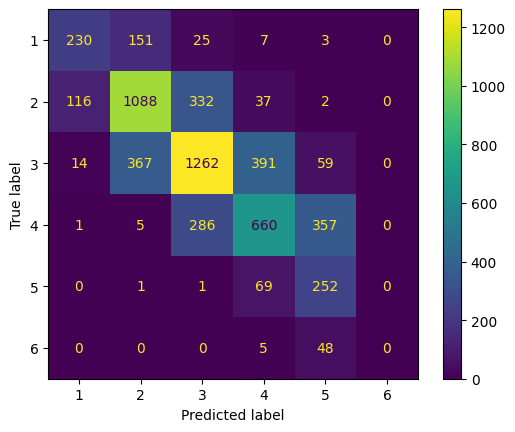

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(
    valid_dataset["score"],
    valid_dataset["valid_pred"],
    labels=[x for x in range(1, 7)],
)

draw_cm = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=[x for x in range(1, 7)]
)

draw_cm.plot()
plt.savefig(f"{MODEL_OUTPUT_PATH}/confusion_matrix.png")
plt.show()

# AWSへのアップロード

In [40]:
# S3へのアップロード
if not DEBUG and UPLOAD_DATA_TO_S3:
    # uninstall
    !sudo rm /usr/bin/aws
    !sudo rm /usr/bin/aws_completer
    !sudo rm -rf /usr/local/aws-cli

    # install
    !curl "https://awscli.amazonaws.com/awscli-exe-linux-x86_64.zip" -o "awscliv2.zip"
    !unzip -o -qq awscliv2.zip
    !sudo ./aws/install --update

    # upload
    output_name = MODEL_OUTPUT_PATH.split("/")[-1]
    os.system(
        f"aws s3 cp --recursive {MODEL_OUTPUT_PATH} s3://automated-essay-scoring/trained_model/{output_name}"
    )

In [42]:
# # ダウンロード（参考）
# !sudo rm /usr/bin/aws
# !sudo rm /usr/bin/aws_completer
# !sudo rm -rf /usr/local/aws-cli

# !curl "https://awscli.amazonaws.com/awscli-exe-linux-x86_64.zip" -o "awscliv2.zip"
# !unzip -o -qq awscliv2.zip
# !sudo ./aws/install --update

# !aws s3 cp --recursive s3://automated-essay-scoring/trained_model/e012-cls-with-qwkloss/ /notebooks/automated_essay_scoring/trained_models/e012-cls-with-qwkloss

# Kaggle Datasetへのupload

In [12]:
if not DEBUG and UPLOAD_DATA_TO_KAGGLE:
    import os
    import json

    from kaggle.api.kaggle_api_extended import KaggleApi

    def dataset_create_new(dataset_name: str, upload_dir: str):
        # if "_" in dataset_name:
        #     raise ValueError("datasetの名称に_の使用は禁止です")
        dataset_metadata = {}
        dataset_metadata["id"] = f"sinchir0/{dataset_name}"
        dataset_metadata["licenses"] = [{"name": "CC0-1.0"}]
        dataset_metadata["title"] = dataset_name
        with open(os.path.join(upload_dir, "dataset-metadata.json"), "w") as f:
            json.dump(dataset_metadata, f, indent=4)
        api = KaggleApi()
        api.authenticate()
        api.dataset_create_new(folder=upload_dir, convert_to_csv=False, dir_mode="tar")

    print(f"Create Dataset name:{DATASET_NAME}, output_dir:{MODEL_OUTPUT_PATH}")
    dataset_create_new(dataset_name=DATASET_NAME, upload_dir=MODEL_OUTPUT_PATH)

Create Dataset name:e020-sigma-05-deberta-v3-base, output_dir:../../trained_models/e020-sigma-05
Starting upload for file cv_score.txt


100%|██████████| 18.0/18.0 [00:00<00:00, 51.0B/s]


Upload successful: cv_score.txt (18B)
Starting upload for file training_args.bin


100%|██████████| 4.93k/4.93k [00:00<00:00, 14.5kB/s]


Upload successful: training_args.bin (5KB)
Starting upload for file tokenizer.json


100%|██████████| 8.26M/8.26M [00:00<00:00, 16.3MB/s]


Upload successful: tokenizer.json (8MB)
Starting upload for file valid_prediction.npy


100%|██████████| 45.2k/45.2k [00:00<00:00, 128kB/s]


Upload successful: valid_prediction.npy (45KB)
Starting upload for file confusion_matrix.png


100%|██████████| 28.9k/28.9k [00:00<00:00, 84.5kB/s]


Upload successful: confusion_matrix.png (29KB)
Starting upload for file config.json


100%|██████████| 1.04k/1.04k [00:00<00:00, 2.98kB/s]


Upload successful: config.json (1KB)
Starting upload for file valid_dataset.tar


100%|██████████| 28.6M/28.6M [00:00<00:00, 49.4MB/s]


Upload successful: valid_dataset.tar (29MB)
Starting upload for file added_tokens.json


100%|██████████| 39.0/39.0 [00:00<00:00, 112B/s]


Upload successful: added_tokens.json (39B)
Starting upload for file tokenizer_config.json


100%|██████████| 1.42k/1.42k [00:00<00:00, 4.12kB/s]


Upload successful: tokenizer_config.json (1KB)
Starting upload for file model.safetensors


100%|██████████| 703M/703M [00:06<00:00, 114MB/s]   


Upload successful: model.safetensors (703MB)
Starting upload for file special_tokens_map.json


100%|██████████| 286/286 [00:00<00:00, 846B/s]  


Upload successful: special_tokens_map.json (286B)
Starting upload for file spm.model


100%|██████████| 2.35M/2.35M [00:00<00:00, 6.10MB/s]


Upload successful: spm.model (2MB)


# ローカルからのデータの削除

In [44]:
if not DEBUG and (UPLOAD_DATA_TO_S3 or UPLOAD_DATA_TO_KAGGLE):
    # ローカルからは削除
    os.system(f"rm -rf {MODEL_OUTPUT_PATH}")

In [45]:
if WANDB:
    wandb.finish()

In [46]:
print("finish Notebook!")